In [2]:
import HoloNet as hn

import os
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import torch

import warnings
warnings.filterwarnings('ignore')
hn.set_figure_params(tex_fonts=True)
sc.settings.figdir = './figure/'

# Load data

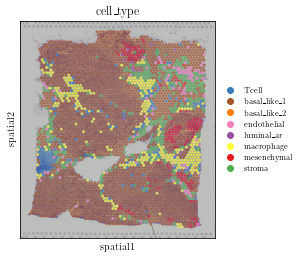

In [4]:
adata = sc.read_h5ad('./data/BRCA_Visium_10x_0504.h5ad')
sc.pl.spatial(adata, color=['cell_type'], size=1.4, alpha=0.7,
             palette=hn.brca_default_color_celltype)

In [5]:
LR_pair_database_PATH = os.path.join('./data/ConnectomeDB2020.csv')

connectomeDB = pd.read_csv(LR_pair_database_PATH,encoding='Windows-1252')
used_connectomeDB = connectomeDB.loc[:,['Ligand gene symbol','Receptor gene symbol','Ligand location']]
used_connectomeDB.columns = ['Ligand_gene_symbol','Receptor_gene_symbol','Ligand_location']

expressed_LR_df = hn.pp.get_expressed_lr_df(used_connectomeDB,adata,expressed_proportion=0.3)
expressed_LR_df.head(3)

,Ligand_gene_symbol,Receptor_gene_symbol,Ligand_location,LR_Pair
0,A2M,LRP1,secreted,A2M:LRP1
1,ADAM15,ITGA5,plasma membrane,ADAM15:ITGA5
2,ADAM15,ITGAV,plasma membrane,ADAM15:ITGAV


# Construct CE network

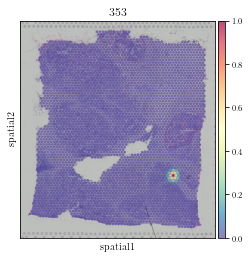

In [5]:
w_best = hn.tl.default_w_visium(adata)
hn.pl.select_w(adata, w_best=w_best)

In [6]:
CE_tensor = hn.tl.compute_ce_tensor(adata=adata, lr_df=expressed_LR_df, w_best=w_best)
CE_tensor_filtered = hn.tl.filter_ce_tensor(ce_tensor=CE_tensor, adata=adata, 
                                            lr_df=expressed_LR_df,w_best=w_best)

100%|██████████| 286/286 [38:00<00:00,  7.97s/it]


# Visualize CE network

In [7]:
X, cell_type_names = hn.pr.get_continuous_cell_type_tensor(adata, continuous_cell_type_slot = 'predicted_cell_type',)

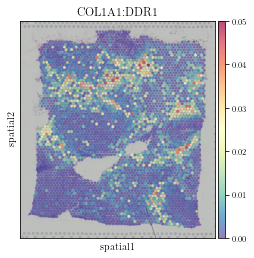

In [8]:
_ = hn.pl.ce_hotspot_plot(CE_tensor_filtered, adata, expressed_LR_df, 'COL1A1:DDR1')

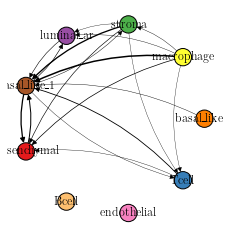

In [9]:
_ = hn.pl.ce_cell_type_network_plot(ce_tensor=CE_tensor_filtered, cell_type_tensor=X, 
                                    cell_type_names=cell_type_names,
                                    lr_df=expressed_LR_df, plot_lr='COL1A1:DDR1', edge_thres=0.2,
                                    palette=hn.brca_default_color_celltype)

In [10]:
cell_cci_centrality = hn.tl.compute_ce_network_eigenvector_centrality(CE_tensor_filtered)
clustered_expressed_LR_df = hn.tl.cluster_lr_based_on_ce(CE_tensor_filtered, adata, expressed_LR_df, 
                                                         w_best=w_best, cell_cci_centrality=cell_cci_centrality)

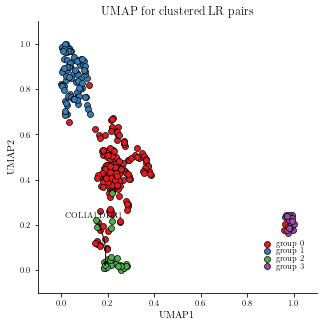

In [11]:
hn.pl.lr_umap(clustered_expressed_LR_df, cell_cci_centrality, plot_lr_list=['COL1A1:DDR1'], linewidths=0.7)

# Predict target gene expression with GNN

In [ ]:
adj = hn.pr.adj_normalize(adj=CE_tensor_filtered, cell_type_tensor=X, only_between_cell_type=True)

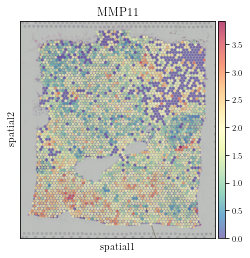

In [8]:
target_all_gene_expr, used_gene_list = hn.pr.get_gene_expr(adata, expressed_LR_df)
target = hn.pr.get_one_case_expr(target_all_gene_expr, cases_list=used_gene_list, used_case_name='MMP11')
sc.pl.spatial(adata, color=['MMP11'], cmap='Spectral_r', size=1.4, alpha=0.7)

100%|██████████| 50/50 [00:00<00:00, 87.11it/s]


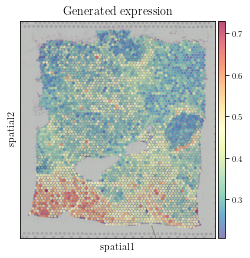

array([[1.        , 0.54181371],
       [0.54181371, 1.        ]])

In [18]:
trained_MGC_model_MMP11_list = hn.pr.mgc_repeat_training(X, adj, target, device='gpu',)
predict_result_MMP11 = hn.pl.plot_mgc_result(trained_MGC_model_MMP11_list, adata, X, adj)
np.corrcoef(predict_result_MMP11.T, target.T)

# Visualize FCE network

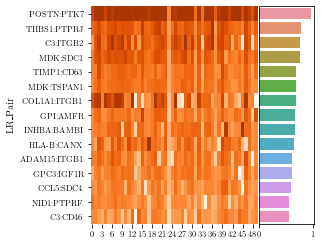

In [19]:
related_LR_df_GCN_result = hn.pl.lr_rank_in_mgc(trained_MGC_model_MMP11_list, expressed_LR_df, 
                                                plot_cluster=False, repeat_attention_scale=True)

100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


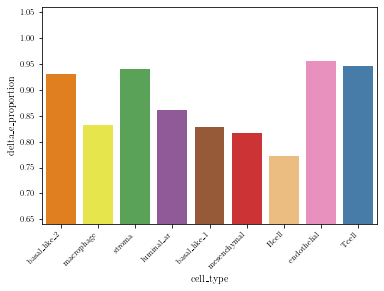

In [20]:
tmp_df = hn.pl.delta_e_proportion(trained_MGC_model_MMP11_list, X, adj,
                                  cell_type_names,
                                  palette = hn.brca_default_color_celltype)

100%|██████████| 50/50 [00:00<00:00, 709.27it/s]


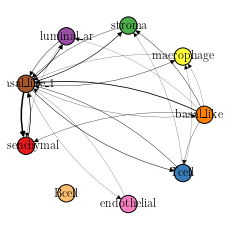

In [21]:
_ = hn.pl.fce_cell_type_network_plot(trained_MGC_model_MMP11_list, expressed_LR_df, X, adj, 
                                     cell_type_names, plot_lr='POSTN:PTK7', edge_thres=0.1,
                                     palette=hn.brca_default_color_celltype)

# Identify genes affected more by CCI

In [9]:
trained_MGC_model_only_type_list_raw, \
trained_MGC_model_type_GCN_list_raw = hn.pr.mgc_training_for_multiple_targets(X, adj, target_all_gene_expr, device='gpu')

100%|██████████| 567/567 [2:15:28<00:00, 14.34s/it]  


In [ ]:
predicted_expr_type_GCN_df_raw = hn.pr.get_mgc_result_for_multiple_targets(trained_MGC_model_type_GCN_list_raw, X, adj,
                                                                           used_gene_list, adata)
predicted_expr_only_type_df_raw = hn.pr.get_mgc_result_for_multiple_targets(trained_MGC_model_only_type_list_raw, X, adj,
                                                                            used_gene_list, adata)

 63%|██████▎   | 358/567 [02:16<01:15,  2.79it/s]

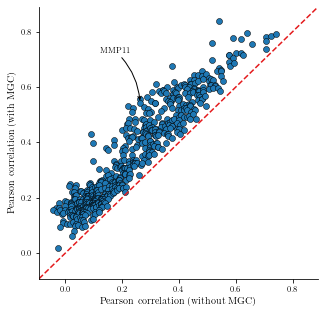

In [13]:
only_type_vs_GCN_all_raw = hn.pl.find_genes_linked_to_ce(predicted_expr_type_GCN_df_raw, predicted_expr_only_type_df_raw, 
                                                     used_gene_list, target_all_gene_expr, 
                                                     plot_gene_list = ['MMP11'], linewidths=0.5)